In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [2]:
def d_depth_proj_ev(depth_and_seed_ops, size, Hamiltonian, cl_ops_list, temp, ts,
                    observables, visualize_H_evs, visualization_nonherm, visualize_expt_vals):
    
    ### building reference states and testing it
    start_time_1 = time.time()
    K_ref, rho_ref = me.build_reference_state(size = size, temp = temp_ref, Hamiltonian = Hamiltonian,
                                       lagrange_op = cl_ops["n_oc_disp"], lagrange_mult = 1., svd = True)
    
    basis_incursive = me.vectorized_recursive_basis(depth_and_ops=depth_and_seed_ops,                                             
                                                    Hamiltonian=Hamiltonian, 
                                                    rho0=rho_ref)
    basis_orth = me.base_orth(ops = basis_incursive, rho0 = rho_ref, sc_prod = me.HS_inner_prod_r, 
                              visualization = False, reinforce_reality=False)
    
    print("using a base of size", len(basis_orth))
    print("rho_ref:", rho_ref)
    ### test 2
    me.basis_orthonormality_check(basis = basis_orth, 
                                  rho0 = rho_ref, 
                                  sc_prod = me.HS_inner_prod_r)
    
    ### constructing the initial state and H-tensor
    
    phi0, rho0 = me.build_rho0_from_basis(basis = basis_orth, temp=temp)
    
    
    
    
    
    # K = cl_ops["x_op"]
    
    # rho0 = (-K).expm()
    # trrho0 = rho0.tr()
    # rho0 = rho0/trrho0
    # phi0[0]+= np.log(trrho0)
    
    Hijtensor = me.H_ij_matrix(Hamiltonian = Hamiltonian, basis = basis_orth, 
                                           rho0 = rho_ref, sc_prod = me.HS_inner_prod_r)
   
    ### constructing the coefficient arrays and the physical states
    rhot_list, phit = me.semigroup_phit_and_rhot_sol(phi0 = phi0, rho0 = rho0, Htensor = Hijtensor,
                                               ts = ts, basis = basis_orth)

    ### test 3
    # herm_rhot_list = me.semigroup_rhos_test(rho_list = rhot_list, 
    #                                        visualization_nonherm = visualization_nonherm, ts = ts)
    
    ### Projected solution
    
    res_proj_ev = [np.array([qutip.expect(obs, rhot) for rhot in rhot_list]) for obs in observables]
    print("Proj ev runtime = ", time.time() - start_time_1)
    
    ### Exact solution 
    
    start_time_2 = time.time()
    #res_exact = exact_evolution(Hamiltonian, rho0, ts, observables)
    #res_exact = qutip.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops = observables)
    
    res_exact = me.mesolve(Hamiltonian, rho0=rho0, tlist=ts, c_ops=None, e_ops=observables)
    
    print("Exact ev runtime = ", time.time() - start_time_2)
    
    if visualize_expt_vals:
        label = ["x_op", "n_oc_op", "magnetization"]
        me.plot_exact_v_proj_ev_avgs(observables, label_ops, ts, res_proj_ev, res_exact)
        
    #max_diff_x = max(res_exact["averages"][:,0][:-1] - res_proj_ev[0])
    #max_diff_n_oc = max(res_exact["averages"][:,1][:-1] - res_proj_ev[1])
    #print(max_diff_x, max_diff_n_oc)
    
    if True:
        plt.plot(res_exact.times,  [qutip.entropy_vn(rho) for rho in res_exact.states],label="Exact")
        plt.plot(res_exact.times[:-1],  [qutip.entropy_vn(rho) for rho in rhot_list], label="Proj")
        plt.title("Von Neumann Entropy")
        plt.legend()
        plt.show()
        
        bures_exact_approx_list = [me.bures(rhot_list[t], res_exact.states[t]) for t in range(len(rhot_list))]
        relentropy_exact_approx_list = [me.rel_entropy(rhot_list[t], res_exact.states[t]) for t in range(len(rhot_list))]
        relentropy_exact_approx_list_prime = [me.rel_entropy(res_exact.states[t], rhot_list[t]) for t in range(len(rhot_list))]
        fig6, ax6 = plt.subplots()
        ax6.plot(ts[:-1], bures_exact_approx_list, label = "Bures metric")
        ax6.plot(ts[:-1], relentropy_exact_approx_list, label = "Relative entropy - Proj. v. Exact")
        ax6.plot(ts[:-1], relentropy_exact_approx_list_prime, label = "Relative entropy - Exact v. Proj.")
        ax6.legend(loc=0)
        ax6.set_title("Metrics - Exact and Proj. ev")
    
    return rho0, rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit

#  N=2

In [3]:
N=2
chain_type = "XX";

Are all the operators Hermitian?: True


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

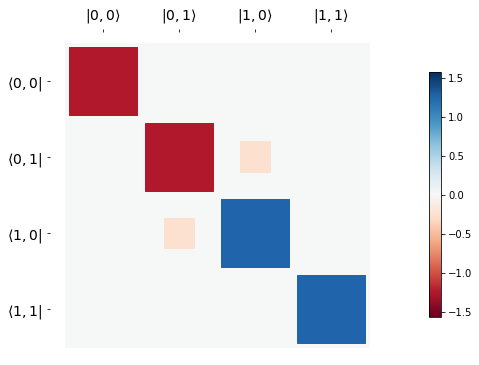

In [4]:

# Construcción de los operadores


spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

#rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
#sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

qutip.hinton(H_H)

## Base completa

In [5]:
k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=2.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,500)  # Tiempos a barrer


zero_body_ops = spin_ops_list[0]
one_body_ops = spin_ops_list[1] + spin_ops_list[2] + spin_ops_list[3]
two_body_ops = [spin_ops_list[mu+1][0]*spin_ops_list[nu+1][1] for mu in range(3) for nu in range(3)]


print([len(zero_body_ops),len(one_body_ops),len(two_body_ops)])

depth_and_seed_ops =  [(1,op)  for op in (zero_body_ops+one_body_ops+two_body_ops)]
print(len(depth_and_seed_ops))


[1, 6, 9]
16


using a base of size 16
rho_ref: Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.441 0.0 0.0 0.0]
 [0.0 0.445 0.029 0.0]
 [0.0 0.029 0.057 0.0]
 [0.0 0.0 0.0 0.055]]
The basis is orthonormal and hermitian
Proj ev runtime =  4.277927875518799
Exact ev runtime =  0.06242632865905762


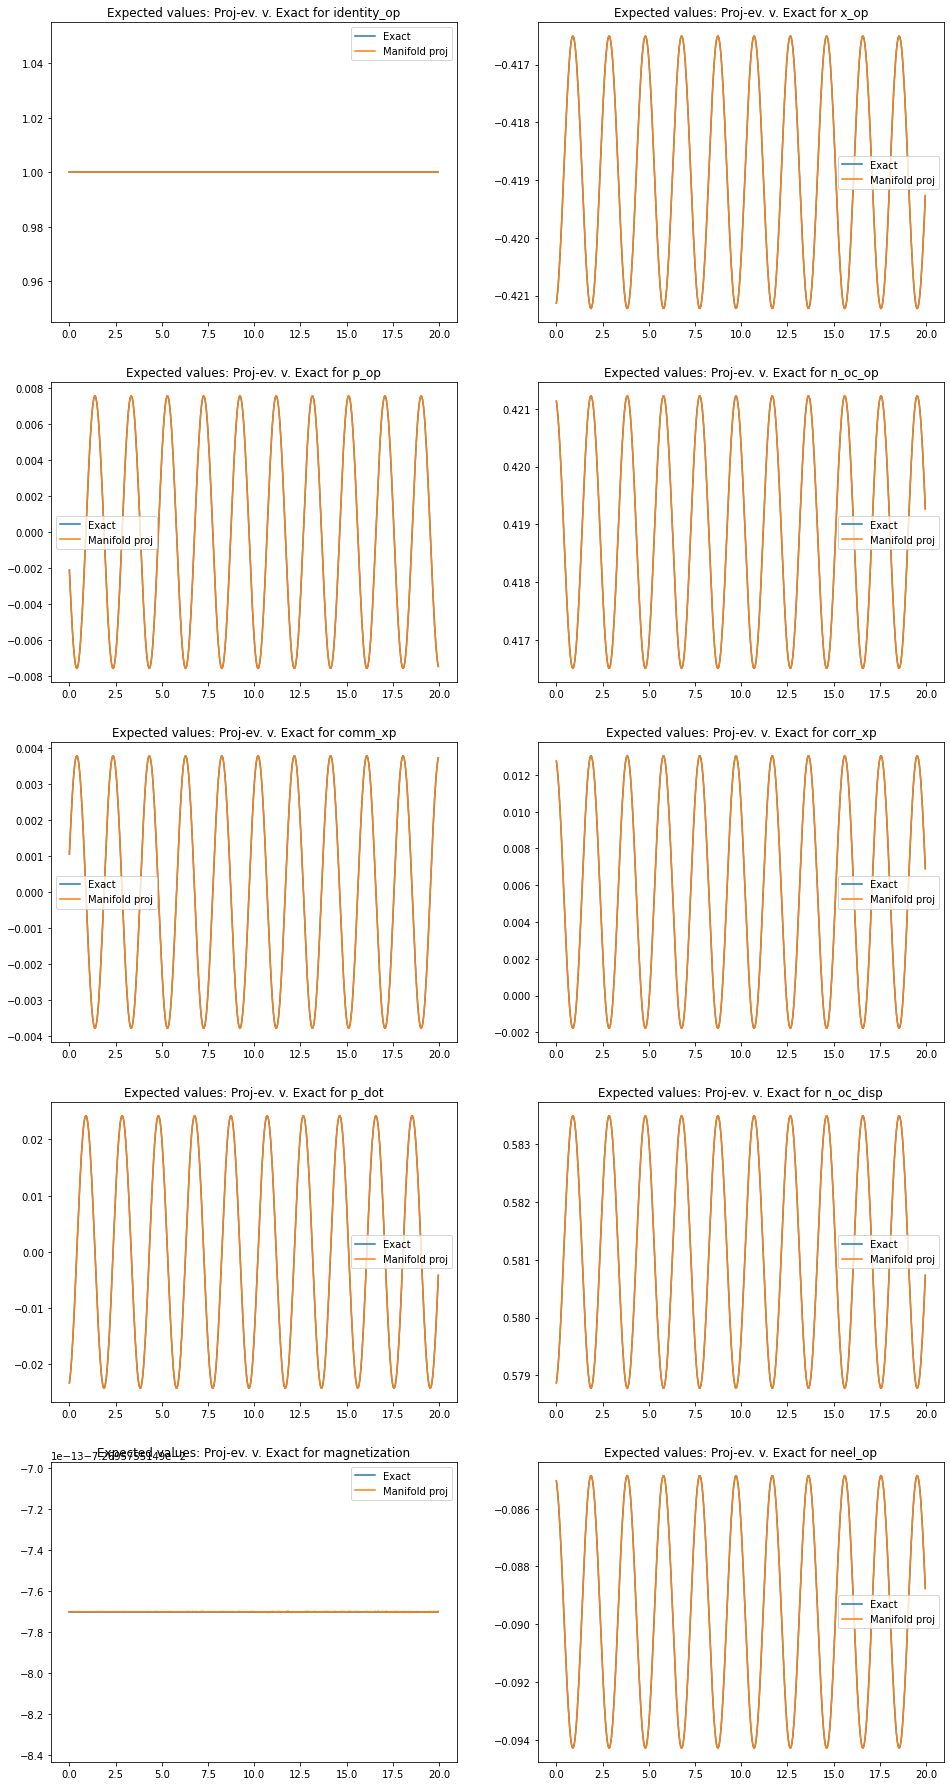

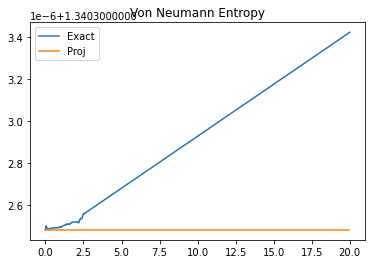

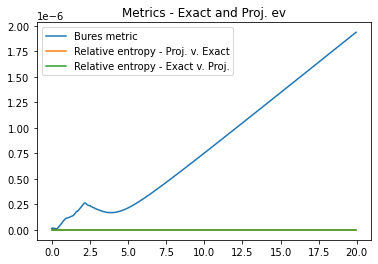

In [6]:
observables = list(cl_ops.values())


#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    cl_ops_list = cl_ops, temp = temp, ts = ts,
    observables = observables, visualize_H_evs = False, 
    visualization_nonherm = False, 
    visualize_expt_vals = True
)

Notar que la entropía del estado "exacto" no es constante, sino que crece, mientras que la del estado aproximado oscila. La amplitud de las oscilaciones parece depender de delta t. Al hacer el paso más pequeño, la fluctuación disminuye. Lo mismo ocurre con las distancias entre el estado exacto y el aproximado.

## Base superficial para x y p

In [7]:
N = 2;k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=1.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,500)  # Tiempos a barrer


depth_and_seed_ops = [(1, cl_ops["identity_op"]),
                      (1, cl_ops["x_op"]),
                      (1, cl_ops["p_op"]),
                      # (1, cl_ops["n_oc_op"]),
                      #(1, cl_ops["n_oc_disp"]),
                      # (1, cl_ops["comm_xp"]),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (1, cl_ops["x_op"]),
                     ]


using a base of size 5
rho_ref: Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.486 0.0 0.0 0.0]
 [0.0 0.495 0.036000000000000004 0.0]
 [0.0 0.036000000000000004 0.01 0.0]
 [0.0 0.0 0.0 0.007]]
The basis is orthonormal and hermitian
Proj ev runtime =  1.4427051544189453
Exact ev runtime =  0.04250979423522949


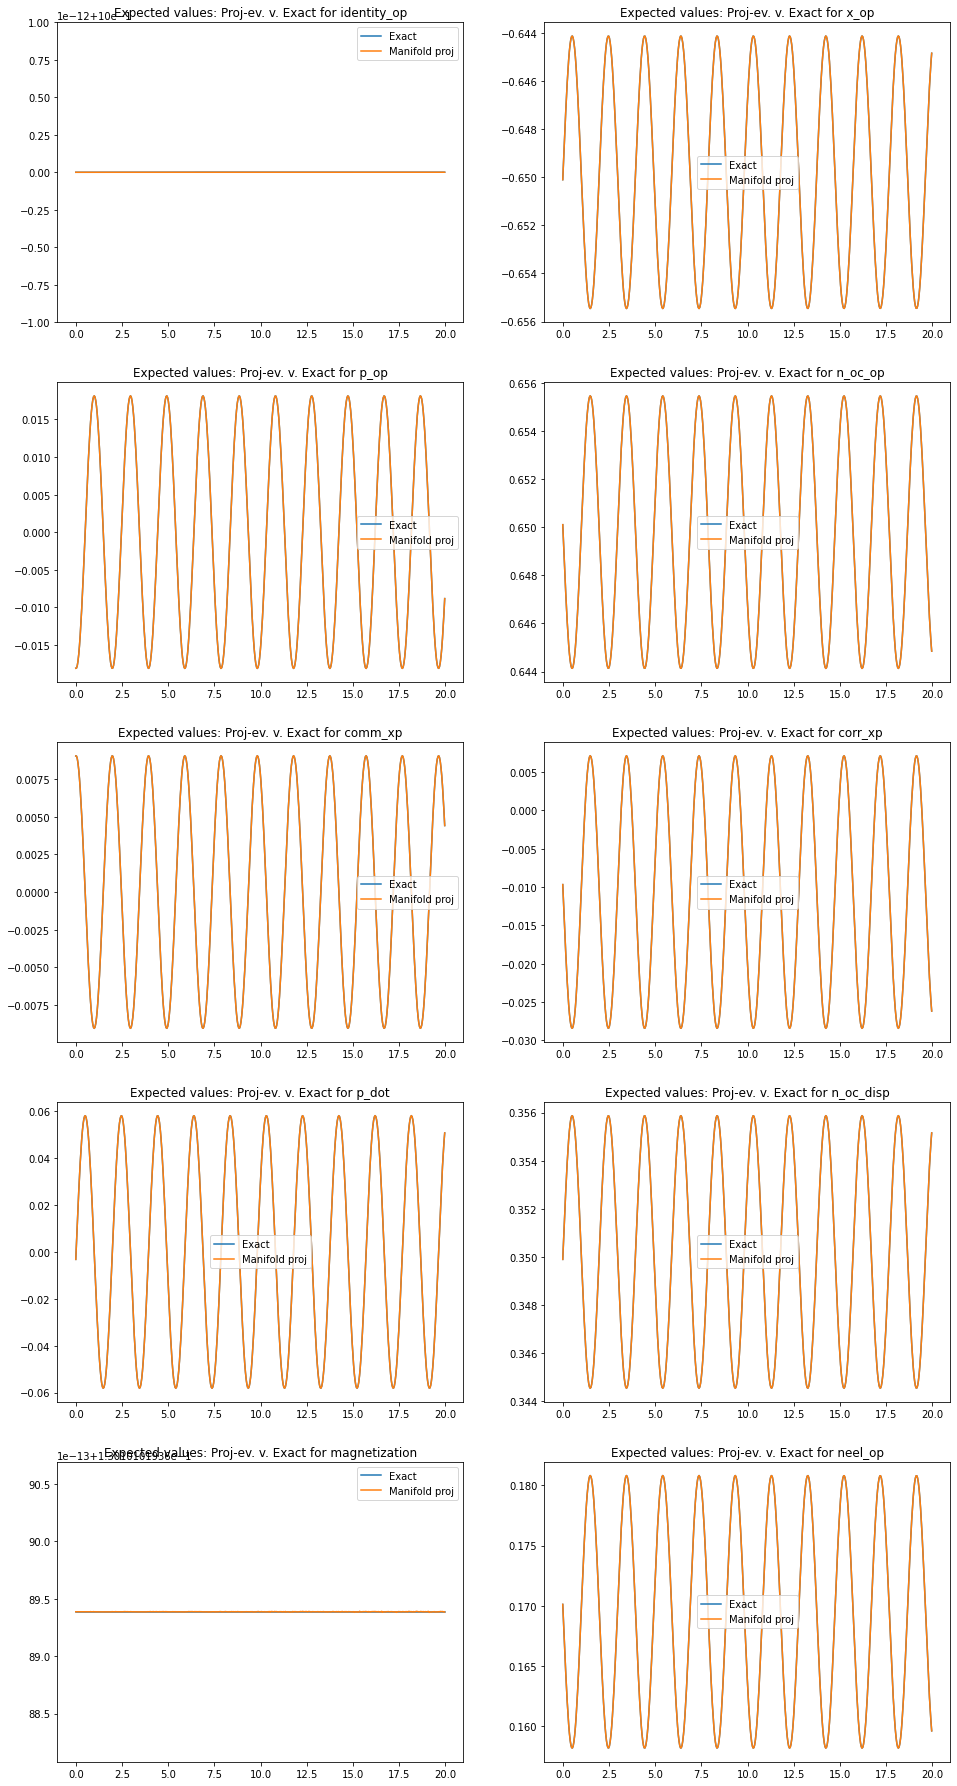

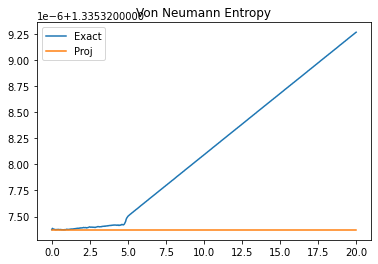

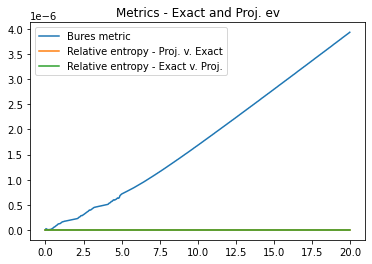

In [8]:
observables = list(cl_ops.values())


#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    cl_ops_list = cl_ops, temp = temp, ts = ts,
    observables = observables, visualize_H_evs = False, 
    visualization_nonherm = False, 
    visualize_expt_vals = True
)

En este caso, al no trabajar con la base completa, el observable de magnetización (la ocupación) se empieza a correr respecto al exacto. Las frecuencias de oscilación se mantienen practicamente iguales que en el caso exacto.

#  N=3

In [9]:
N=3
chain_type = "XX"; 

Are all the operators Hermitian?: True


(<Figure size 576x432 with 2 Axes>, <AxesSubplot:>)

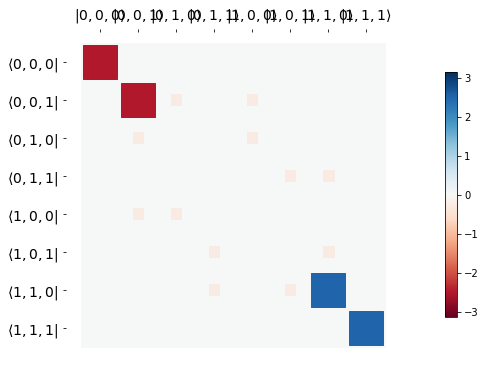

In [10]:

# Construcción de los operadores


spin_ops_list = me.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]

### Heisenberg Hamiltonian
Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

#rho_tolerance = (-.5 * H_H).expm(); #rho_tolerance = rho_tolerance/rho_tolerance.tr()
#sigma_tolerance = (-.4 * H_H).expm(); #sigma_tolerance = sigma_tolerance/sigma_tolerance.tr()

### classical operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))

qutip.hinton(H_H)

## Base completa

In [11]:
k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=1000.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,100)  # Tiempos a barrer


H_H_powers = [(1, H_H),(1, H_H*H_H),(1, H_H*H_H*H_H*H_H)]

    
depth_and_seed_ops = [(1, cl_ops["identity_op"]),
                      (30, cl_ops["x_op"]),
                      (1, cl_ops["p_op"]),
                      (1, cl_ops["n_oc_op"]),
                      (1, cl_ops["n_oc_disp"]),                
                      (1, cl_ops["comm_xp"]),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (1, cl_ops["x_op"]),
                      (4, cl_ops["magnetization"]),
                     ] + H_H_powers


Operator at depth 1 is null
using a base of size 20
rho_ref: Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.125 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.125 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.125 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.124 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.124]]
The basis is orthonormal and hermitian
Proj ev runtime =  2.237616539001465
Exact ev runtime =  0.021310091018676758


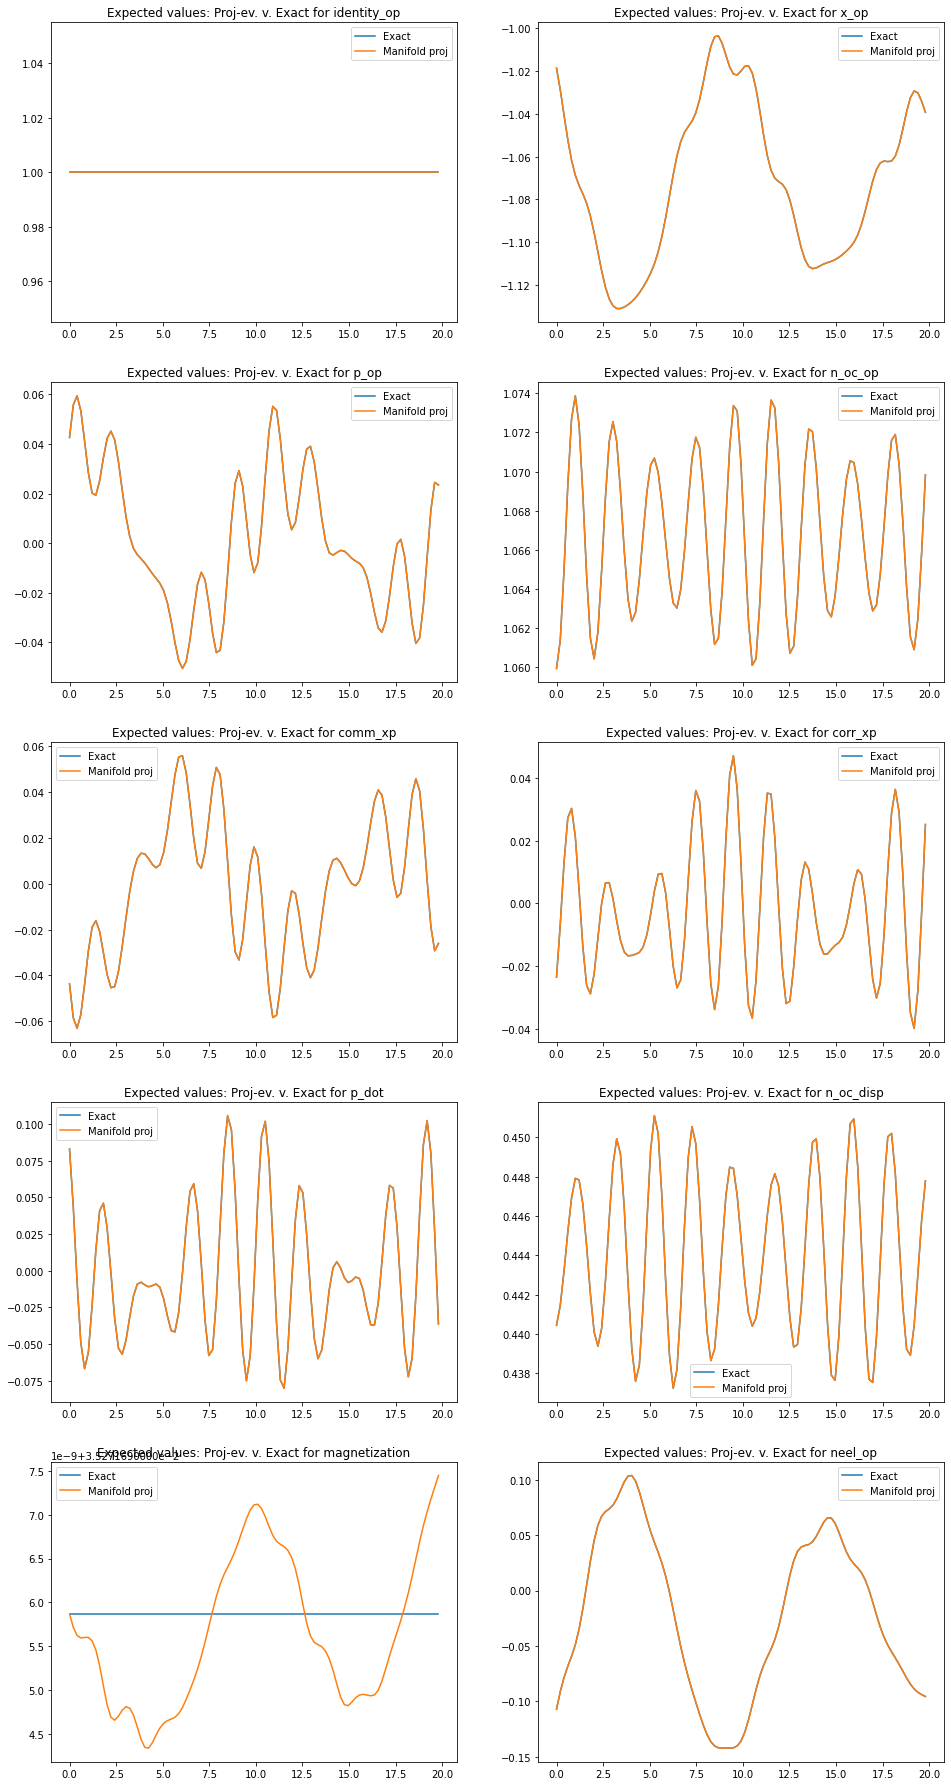

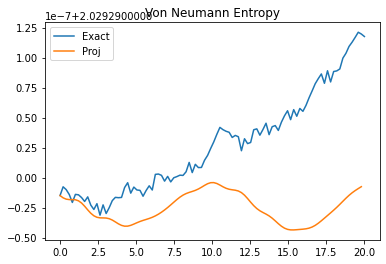

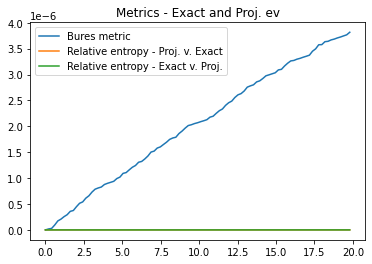

In [12]:
observables = list(cl_ops.values())


#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    cl_ops_list = cl_ops, temp = temp, ts = ts,
    observables = observables, visualize_H_evs = False, 
    visualization_nonherm = False, 
    visualize_expt_vals = True
)

Notar que la entropía del estado "exacto" no es constante, sino que crece, mientras que la del estado aproximado oscila. La amplitud de las oscilaciones parece depender de delta t. Al hacer el paso más pequeño, la fluctuación disminuye. Lo mismo ocurre con las distancias entre el estado exacto y el aproximado.

## Base superficial para x y p

In [19]:
N = 2; k_B = 1; 
temp = 10.;           # Temperatura para el estado inicial
temp_ref=1000.;       # Temperatura para el estado de referencia
ts = np.linspace(0, 20,300)  # Tiempos a barrer


depth_and_seed_ops = [(1, cl_ops["identity_op"]),
                      (1, cl_ops["x_op"]),
                      (1, cl_ops["p_op"]),
                      (1, H_H),
                      # (1, cl_ops["n_oc_op"]),
                      #(1, cl_ops["n_oc_disp"]),
                      # (1, cl_ops["comm_xp"]),
                      (1, cl_ops["corr_xp"]),
                      (1, cl_ops["p_dot"]),
                      (1, cl_ops["x_op"]),
                     ]


using a base of size 6
rho_ref: Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.125 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.125 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.125 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.124 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.124]]
The basis is orthonormal and hermitian
Proj ev runtime =  1.4015917778015137
Exact ev runtime =  0.04286694526672363


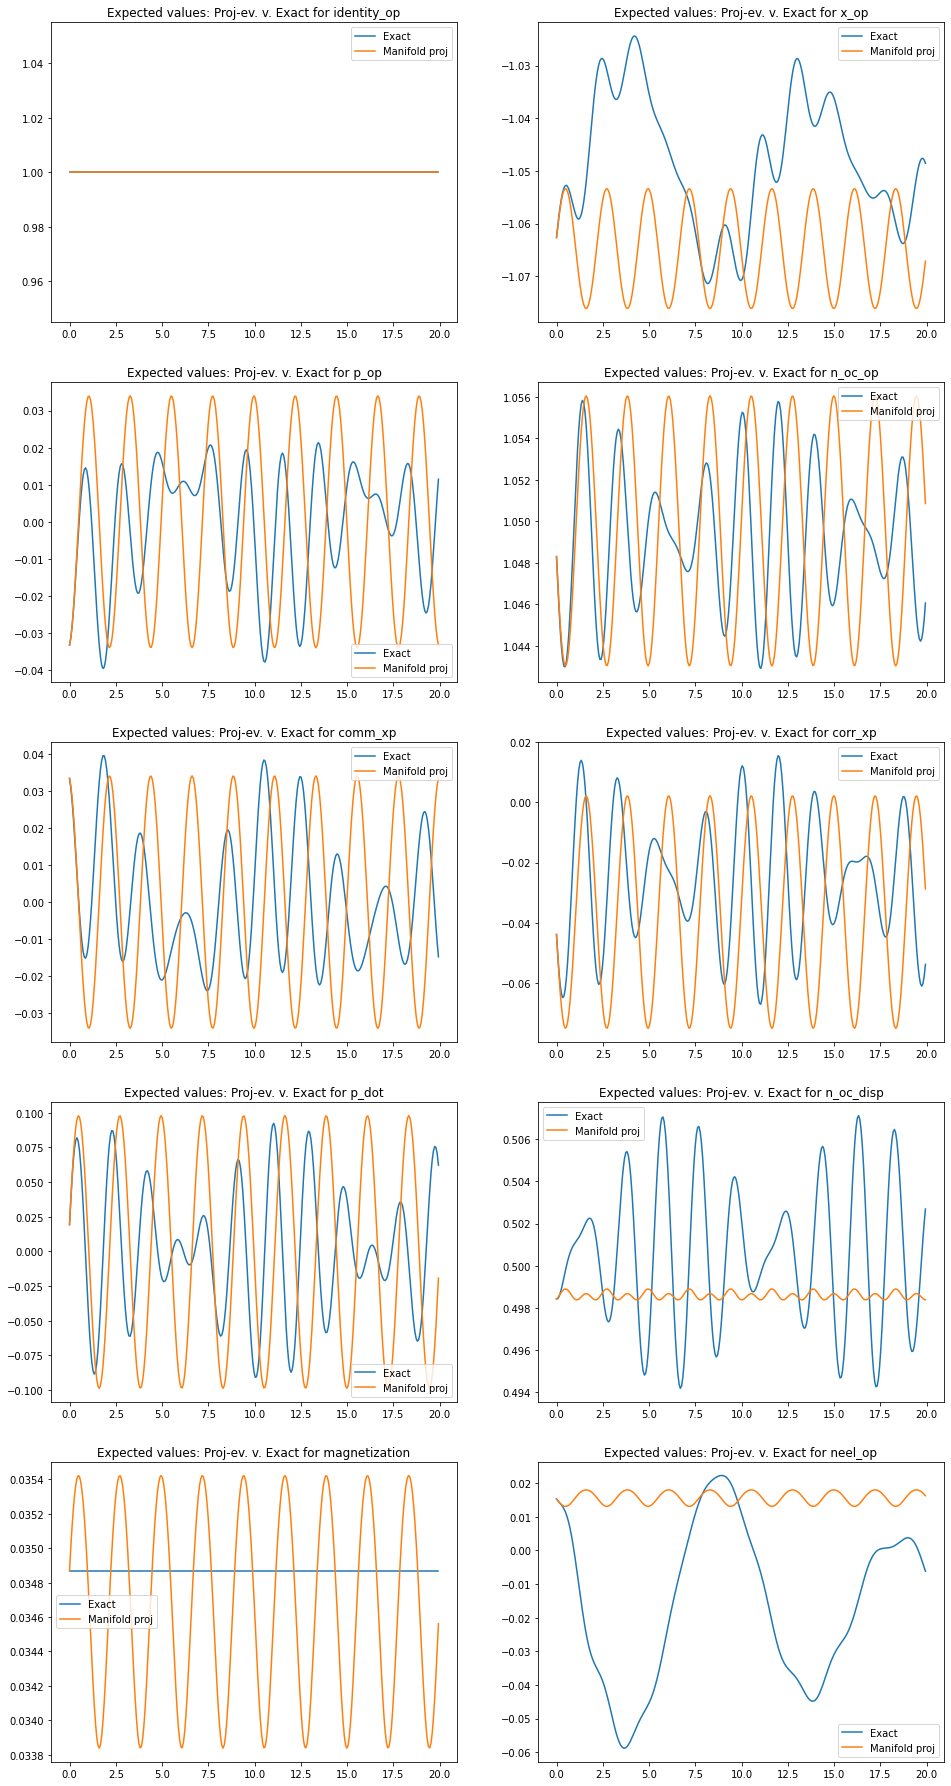

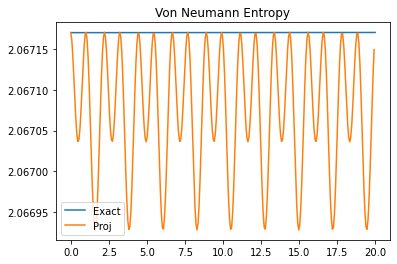

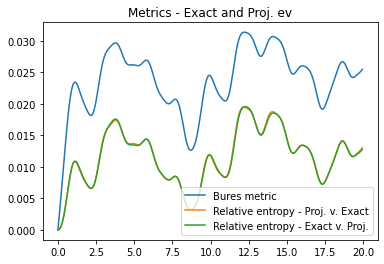

In [20]:
observables = list(cl_ops.values())


#seed_ops_list = [cl_ops["p_dot"], cl_ops["x_op"], cl_ops["n_oc_op"], cl_ops["neel_op"]]
rho0, herm_rhot_list, res_exact, res_proj_ev, rhot_list, basis_orth, phit = d_depth_proj_ev(
    depth_and_seed_ops = depth_and_seed_ops,
    size = N,
    Hamiltonian = H_H, 
    cl_ops_list = cl_ops, temp = temp, ts = ts,
    observables = observables, visualize_H_evs = False, 
    visualization_nonherm = False, 
    visualize_expt_vals = True
)

En este caso, al no trabajar con la base completa, el observable de magnetización (la ocupación) se empieza a correr respecto al exacto. Las frecuencias de oscilación se mantienen practicamente iguales que en el caso exacto.

# Cosas para testear:

1. dos operadores con índices de recursividad d1 y d2, le ganan a un único operador de índice (d1+d2)?
2. como cuantificar el "poder" o el operador que más domina en la expansión? lambda más grande?
3. tiene sentido usar el algoritmo de Strassen acá?
4. plotear Bures y entropías relativas entre estados
5. intentar con funciones de dos puntos y Neels/Magnetizations